# DRIVE MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, CuDNNLSTM, LSTM, Conv1D,UpSampling1D, MaxPool1D,MaxPooling1D, Permute, Reshape
from keras.optimizers import RMSprop, adam
from keras.utils import to_categorical

import pywt
import pandas as pd
from matplotlib import cm

from mpl_toolkits.mplot3d import Axes3D

from imblearn.over_sampling import SMOTE
from imblearn.base import BaseSampler
from collections import Counter # counts the number of elements per class ({0: 5050, 1: 37})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# DATA PROCESSING

In [0]:
def RPN(x):
    '''
    Calcule la RPN d'un signal (Relative Power Noise)
    input :
        x = array numpy, le signal dont on souhaite calculer la RPN
        
    output :
        x_RPN = array numpy, la RPN du signal
        '''
    mean = np.mean(x,axis=1).reshape(x.shape[0],1)
    return (x-mean)/mean
  
def shuffle(x,y):
    # shuffle
    index = np.arange(y.shape[0])
    np.random.shuffle(index)
    x = x[index]
    y = y[index]
    
    return x,y
    
def bootstrap(x_train,y_train,inv=True) :
    if inv :
      x_train,y_train = inv_data(x_train,y_train)
      
    x_train1 = x_train[np.where(y_train == 1)[0]] #Separation du train_set selon le label
    x_train0 = x_train[np.where(y_train == 0)[0]]
    index_train = np.random.randint(0,x_train1.shape[0] , size=x_train0.shape[0]) #genere une liste d'index 
                                                                                  #aléatoire pour equilibrer les données
    x_train_1_boot = x_train1[index_train]
    y_train_boot = np.concatenate((np.ones(x_train0.shape[0]),np.zeros(x_train0.shape[0]))) #on génère une liste de labels avec autant de 1 que de 0
    x_train_boot = np.concatenate((x_train_1_boot,x_train0)) #on rassemble les données une fois équilibrées
    
    x_train_boot,y_train_boot  = shuffle(x_train_boot,y_train_boot)
    
    return x_train_boot,y_train_boot

def dataload(path='data/',merge=True) :
    # Loading datas
    data_train = pd.read_csv(path+'exoTrain.csv')
    data_test = pd.read_csv(path+'exoTest.csv')
    
    # transformation des label en array de 0 et 1
    y_train = np.array(data_train["LABEL"])-1
    y_test = np.array(data_test['LABEL'])-1
    
    # on charge les features
    x_train = np.array(data_train.drop('LABEL',axis=1))
    x_test = np.array(data_test.drop('LABEL',axis=1))
    
    if merge :
      data = np.concatenate((x_train,x_test))
      y = np.concatenate((y_train,y_test))
      data0 = data[np.where(y==0)[0]]
      y0 = y[np.where(y==0)[0]]
      data1 = data[np.where(y==1)[0]]
      y1 = y[np.where(y==1)[0]]
      
      x_train0,x_test0,y_train0,y_test0 = train_test_split(data0,y0, test_size = 0.1)
      x_train1,x_test1,y_train1,y_test1 = train_test_split(data1,y1, test_size = 0.1)
      
      x_train = np.concatenate((x_train0,x_train1))
      y_train = np.concatenate((y_train0,y_train1))
      x_test = np.concatenate((x_test0,x_test1))
      y_test = np.concatenate((y_test0,y_test1))
      
      x_train,y_train = shuffle(x_train,y_train)
      x_test,y_test = shuffle(x_test,y_test)
    
    return x_train,y_train,x_test,y_test

def pcaPlot(X, y, descr= 'temporel',plot_samples = 500):
  '''
  Defines and 10 components PCA of the dataset X and plots the first 3
  '''
  pca = PCA(n_components=10)
  x_PCA = pca.fit_transform(X)

  # let's visualize the data in 3d
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_zlabel('Principal Component 3', fontsize = 15)
  ax.set_title('ACP du signal ' + descr, fontsize = 20)
  targets = [0,1]
  colors = ['b', 'r']
  x_PCA_plot = x_PCA[0:plot_samples]

  for target, color in zip(targets,colors):
      indexes = np.where(y[0:plot_samples] == target)
      ax.scatter(x_PCA_plot[indexes,0]
                , x_PCA_plot[indexes,1],
                x_PCA_plot[indexes,2]
                , c = color
                , s = 50)
  ax.legend(['pas d\'exoplanetes', 'exoplanetes'])
  ax.grid()
  plt.show()
  return None

#Make an identity sampler
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y

def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def SMOTE_plot(x_train, y_train):
  sampler = FakeSampler()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  plot_resampling(x_train, y_train, sampler, ax1)
  ax1.set_title('Original data - y={}'.format(Counter(y_train)))

  plot_resampling(x_train, y_train, SMOTE(random_state = 0), ax2)
  ax2.set_title('Resampling using {}'.format(SMOTE(random_state=0).__class__.__name__))
  fig.tight_layout()
  plt.show()
  return None

def transform_dataset(X, mode='wavelet', wname='db5',nsamples=10):
  if mode == 'wavelet':
    return pywt.dwt(X, wname)[0][:,0:nsamples]

  elif mode == 'fft':
    return np.abs(np.fft.fft(X))[:,0:nsamples]

  elif mode == 'all_in':
    allz = np.abs(np.fft.fft(X))[:,0:nsamples]
    wnames = ['db5','sym5','coif5','bior2.4']
    for wn in wnames:
      np.append(allz, pywt.dwt(X, wn)[0][:,0:nsamples], axis=1)
    return allz

def scale_datasets(X_train, X_test, param='standardScaling', reshape=True):
  SC = StandardScaler()
  train_shape = X_train.shape
  test_shape = X_test.shape
    
  if param == 'standardScaling':
    SC.fit(X_train)
    if reshape:
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1],1), SC.transform(X_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return SC.transform(X_train), SC.transform(X_test)

  elif param == 'RPN':
    
    mean_train = np.mean(X_train,axis=1).reshape(X_train.shape[0],1)
    mean_test = np.mean(X_test,axis=1).reshape(X_test.shape[0],1)
    
    norm_train = np.max(np.abs(X_train),axis=1).reshape(-1,1)#np.linalg.norm(X_train,axis=1).reshape(-1,1)
    norm_test = np.max(np.abs(X_test),axis=1).reshape(-1,1)#np.linalg.norm(X_test,axis=1).reshape(-1,1)
    
    if reshape:
      return ((X_train-mean_train)/norm_train) .reshape(train_shape[0],train_shape[1],1) , ((X_test-mean_test)/norm_test) .reshape(test_shape[0],test_shape[1],1)
    else :
      return ((X_train-mean_train)/norm_train)  , ((X_test-mean_test)/norm_test) 
    
    
  elif param == 'transpose':
    X_train = np.transpose(X_train)
    if train_shape != test_shape :
      X_test = np.tile(X_test,(10,1))[0:train_shape[0]]
    X_test = np.transpose(X_test)
    SC.fit(X_train)
    if reshape:
      return np.transpose(SC.transform(X_train)).reshape(train_shape[0],train_shape[1],1), np.transpose(SC.transform(X_test))[0:test_shape[0]].reshape(test_shape[0],test_shape[1],1)
    else :
      return np.transpose(SC.transform(X_train)), np.transpose(SC.transform(X_test))[0:test_shape[0]]
    
  elif param == 'flatten':
    X_train = X_train.flatten().reshape((-1,1))
    X_test = X_test.flatten().reshape((-1,1))
    SC.fit(X_train)
    if reshape:
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1],1), SC.transform(X_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1]), SC.transform(X_test).reshape(test_shape[0],test_shape[1])
  
  elif param == 'norm':
    norm_train = np.linalg.norm(X_train,axis=1).reshape(-1,1)
    norm_test = np.linalg.norm(X_test,axis=1).reshape(-1,1)
    if reshape:
      return (X_train/norm_train).reshape(train_shape[0],train_shape[1],1), (X_test/norm_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return X_train/norm_train, X_test/norm_test
    
  elif param == 'norm_flatten':
    norm_train = np.linalg.norm(X_train)
    norm_test = np.linalg.norm(X_test,axis=1).reshape(-1,1)
    if reshape:
      return (X_train/norm_train).reshape(train_shape[0],train_shape[1],1), (X_test/norm_train).reshape(test_shape[0],test_shape[1],1)
    else :
      return X_train/norm_train, X_test/norm_train

def inv_data(X, y):
  X_flipped = np.flip(X[np.where(y == 1)[0]], 1)
  y_flipped = np.ones((X_flipped.shape[0]))
  return np.concatenate((X, X_flipped)), np.concatenate((y, y_flipped))

# METRICS


In [0]:
def metrics_scores_cross(y_true, pred, display=False):
  '''
  Evaluates predictions of a model
  Input : 
    real : numpy array, real labels
    result : numpy array, predicted labels
    display : parameter (Boolean), if True then prints all metrics value
  Output :
    confusion : numpy array, confusion matrix
  '''

  pred_int = np.rint(pred)
  confusion = confusion_matrix(y_true, pred_int)
  fpr, tpr, _ = roc_curve(y_true, pred)
  roc_score = roc_auc_score(y_true, pred)
  
  if display:
    print('Precision :')
    print(precision_score(y_true, pred_int))
    print('Recall :')
    print(recall_score(y_true, pred_int))
    print('F1 Score :')
    print(f1_score(y_true, pred_int))
    print('MSE :')
    print('')
    print(mean_squared_error(y_true, pred_int))
    print('confusion_matrix : ')
    print(confusion)
    print('')
    print('area under roc curve : ',roc_score)
    plt.plot(fpr,tpr)
    plt.xlabel('false positiv rate')
    plt.ylabel('true positiv rate')
    plt.show()
  
  return confusion, roc_score

def recall(y_true, y_pred):
  '''
  Defines Recall metric.
  '''

  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
  '''
  Defines Precision metric.
  '''

  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  return true_positives / (predicted_positives + K.epsilon())

def f1(y_true, y_pred):
  '''
  Defines f1 metric.
  '''
  
  preci = precision(y_true, y_pred)
  rec = recall(y_true, y_pred)
  return 2*((preci*rec)/(preci+rec+K.epsilon()))


# CROSS VALIDATION


## Data load

In [0]:
def data_load_for_cross(path='drive/My Drive/data/'):
  '''
  Loads data into one single dataset. 
  Takes only the path as parameter and returns two numpy arrays X and y
  '''

  # Loading data
  data_train = pd.read_csv(path+'exoTrain.csv')
  data_test = pd.read_csv(path+'exoTest.csv')
  
  # Transform labels into arrays of zeros and ones
  y_train = np.array(data_train["LABEL"])-1
  y_test = np.array(data_test['LABEL'])-1
  
  # Load features
  x_train = np.array(data_train.drop('LABEL',axis=1))
  x_test = np.array(data_test.drop('LABEL',axis=1))
  
  # Merge datasets
  X = np.concatenate((x_train,x_test))
  y = np.concatenate((y_train,y_test))

  return X, y

In [0]:
x, y = data_load_for_cross()

## Functions


In [0]:
def maxinet_cross(x_train,y_train,x_test,y_test, tst=False):
  model = Sequential()

  model.add(Conv1D(16, 200, activation='relu', padding='same', input_shape=x_train.shape[1:]))
  model.add(MaxPooling1D(4, padding='same'))
  model.add(Conv1D(8, 100, activation='relu', padding='same'))
  model.add(MaxPooling1D(4, padding='same'))
  model.add(Conv1D(4, 10, activation='relu', padding='same'))
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(200, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(70, return_sequences=True)) 
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(10)) 
  model.add(Dropout(0.2))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[recall, precision]) #[f1, precision, "accuracy"]
  if tst:
    model.fit(x_train, y_train,
                    epochs=1,
                    shuffle = True,
                    batch_size=128)
  else:
    model.fit(x_train, y_train,
                    epochs=6,
                    shuffle = True,
                    batch_size=32)
  

  return model.predict(x_test)

In [0]:
def cross_validation(X, y, splits=5, testing=False):
  # Separate exoplanet stars from non-exoplanet stars
  x_stars = X[np.where(y==0)]
  y_stars = y[np.where(y==0)]
  x_exo = X[np.where(y==1)]
  y_exo = y[np.where(y==1)]

  # Create splits
  kf = KFold(n_splits=splits, random_state=None, shuffle=False)
  split_stars = kf.split(x_stars)
  split_exo = kf.split(x_exo)
  scores = np.zeros((splits, 2, 2))
  ROC = np.zeros(splits)
  ID_issues = np.zeros(splits)

  for k in range(splits):
    # A bit of info
    print("Running split number ", k + 1)

    # Define splits
    spS = next(split_stars)
    spE = next(split_exo)
    idx_tra_S = spS[0]
    idx_tst_S = spS[1]
    idx_tra_E = spE[0]
    idx_tst_E = spE[1]

    # Create train and test sets
    x_tra = np.concatenate((x_stars[idx_tra_S], x_exo[idx_tra_E]))
    y_tra = np.concatenate((y_stars[idx_tra_S], y_exo[idx_tra_E]))
    x_tst = np.concatenate((x_stars[idx_tst_S], x_exo[idx_tst_E]))
    y_tst = np.concatenate((y_stars[idx_tst_S], y_exo[idx_tst_E]))

    # Shuffle datasets
    x_tra, y_tra = shuffle(x_tra, y_tra)
    x_tst, y_tst = shuffle(x_tst, y_tst)

    # Bootstrap datasets
    x_tra, y_tra = bootstrap(x_tra, y_tra)
    x_tst, y_tst = bootstrap(x_tst, y_tst, inv=False)

    # Scale datasets
    x_tra, x_tst = scale_datasets(x_tra, x_tst, param='RPN')

    # Run and evaluate NN
    pred = maxinet_cross(x_tra, y_tra, x_tst, y_tst, tst=testing)
    scores[k], ROC[k] = metrics_scores_cross(y_tst, pred,display=True)

  return scores, ROC

## Testing

Running split number  1
Epoch 1/6
9624/9624 [==============================] - 17s 2ms/step - loss: 0.6117 - recall: 0.5457 - precision: 0.6632
Epoch 2/6
9624/9624 [==============================] - 13s 1ms/step - loss: 0.2812 - recall: 0.9264 - precision: 0.8790
Epoch 3/6
9624/9624 [==============================] - 13s 1ms/step - loss: 0.2645 - recall: 0.9514 - precision: 0.8960
Epoch 4/6
9624/9624 [==============================] - 13s 1ms/step - loss: 0.3219 - recall: 0.9109 - precision: 0.8585
Epoch 5/6
9624/9624 [==============================] - 13s 1ms/step - loss: 0.2229 - recall: 0.9609 - precision: 0.8988
Epoch 6/6
9624/9624 [==============================] - 13s 1ms/step - loss: 0.1348 - recall: 0.9845 - precision: 0.9487
Precision :
0.9114642451759364
Recall :
1.0
F1 Score :
0.9536817102137767
MSE :

0.048567870485678705
confusion_matrix : 
[[725  78]
 [  0 803]]

area under roc curve :  0.9768148397432418


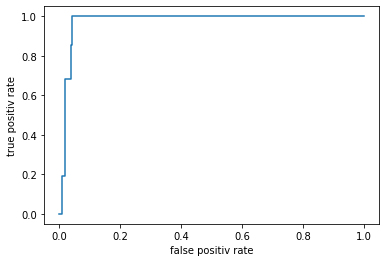

Running split number  2
Epoch 1/6
9626/9626 [==============================] - 18s 2ms/step - loss: 0.6919 - recall: 0.4795 - precision: 0.5073
Epoch 2/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.6501 - recall: 0.5297 - precision: 0.6185
Epoch 3/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.6046 - recall: 0.5460 - precision: 0.7744
Epoch 4/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.4947 - recall: 0.6999 - precision: 0.8371
Epoch 5/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2609 - recall: 0.9079 - precision: 0.9091
Epoch 6/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1795 - recall: 0.9452 - precision: 0.9285
Precision :
0.9611510791366906
Recall :
0.8329177057356608
F1 Score :
0.8924515698062793
MSE :

0.10037406483790523
confusion_matrix : 
[[775  27]
 [134 668]]

area under roc curve :  0.9781018152872184


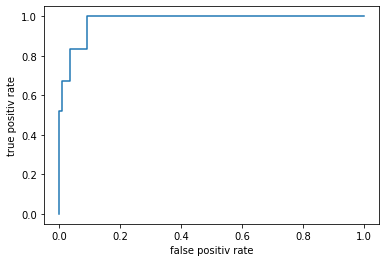

Running split number  3
Epoch 1/6
9626/9626 [==============================] - 18s 2ms/step - loss: 0.6928 - recall: 0.5043 - precision: 0.4851
Epoch 2/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.6876 - recall: 0.5135 - precision: 0.5276
Epoch 3/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.5420 - recall: 0.7176 - precision: 0.7662
Epoch 4/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.5323 - recall: 0.6962 - precision: 0.7488
Epoch 5/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.4387 - recall: 0.7800 - precision: 0.8655
Epoch 6/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2677 - recall: 0.8965 - precision: 0.9338
Precision :
0.9336437718277066
Recall :
1.0
F1 Score :
0.9656833232992174
MSE :

0.035536159600997506
confusion_matrix : 
[[745  57]
 [  0 802]]

area under roc curve :  0.9829400936561339


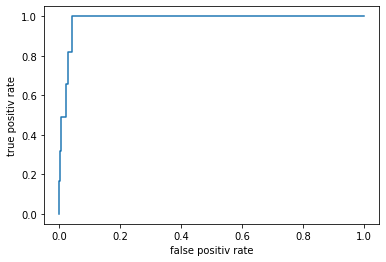

Running split number  4
Epoch 1/6
9626/9626 [==============================] - 18s 2ms/step - loss: 0.6196 - recall: 0.6351 - precision: 0.7133
Epoch 2/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.3680 - recall: 0.8940 - precision: 0.8396
Epoch 3/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2353 - recall: 0.9401 - precision: 0.9085
Epoch 4/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2199 - recall: 0.9299 - precision: 0.9306
Epoch 5/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1325 - recall: 0.9737 - precision: 0.9538
Epoch 6/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1453 - recall: 0.9666 - precision: 0.9513
Precision :
0.9150779896013865
Recall :
0.6583541147132169
F1 Score :
0.7657722987672226
MSE :

0.2013715710723192
confusion_matrix : 
[[753  49]
 [274 528]]

area under roc curve :  0.8842233568199203


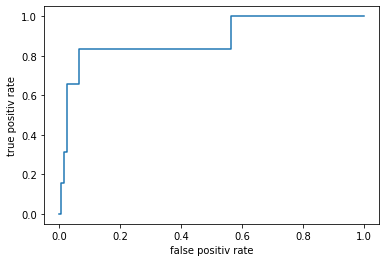

Running split number  5
Epoch 1/6
9626/9626 [==============================] - 19s 2ms/step - loss: 0.5988 - recall: 0.7189 - precision: 0.6951
Epoch 2/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.3927 - recall: 0.8713 - precision: 0.8321
Epoch 3/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2437 - recall: 0.9467 - precision: 0.9060
Epoch 4/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2883 - recall: 0.9311 - precision: 0.8944
Epoch 5/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2787 - recall: 0.9288 - precision: 0.8832
Epoch 6/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1912 - recall: 0.9753 - precision: 0.9187
Precision :
0.9584086799276673
Recall :
0.6608478802992519
F1 Score :
0.782287822878229
MSE :

0.18391521197007482
confusion_matrix : 
[[779  23]
 [272 530]]

area under roc curve :  0.8563286297970784


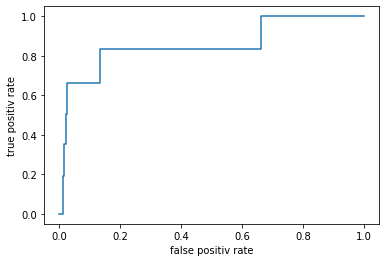

Running split number  6
Epoch 1/6
9626/9626 [==============================] - 19s 2ms/step - loss: 0.5683 - recall: 0.7070 - precision: 0.6822
Epoch 2/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.4098 - recall: 0.8711 - precision: 0.8318
Epoch 3/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2191 - recall: 0.9676 - precision: 0.9110
Epoch 4/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1609 - recall: 0.9758 - precision: 0.9341
Epoch 5/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1441 - recall: 0.9739 - precision: 0.9486
Epoch 6/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1151 - recall: 0.9847 - precision: 0.9532
Precision :
0.9651474530831099
Recall :
0.4488778054862843
F1 Score :
0.6127659574468085
MSE :

0.28366583541147133
confusion_matrix : 
[[789  13]
 [442 360]]

area under roc curve :  0.8763331695698409


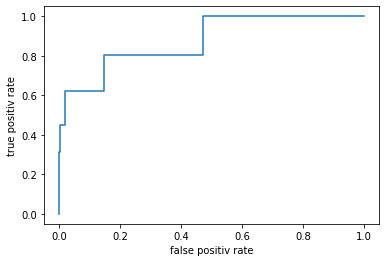

Running split number  7
Epoch 1/6
9626/9626 [==============================] - 19s 2ms/step - loss: 0.5645 - recall: 0.7479 - precision: 0.7312
Epoch 2/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.3450 - recall: 0.9242 - precision: 0.8473
Epoch 3/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.2597 - recall: 0.9405 - precision: 0.9029
Epoch 4/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1537 - recall: 0.9867 - precision: 0.9329
Epoch 5/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.1231 - recall: 0.9836 - precision: 0.9557
Epoch 6/6
9626/9626 [==============================] - 13s 1ms/step - loss: 0.3373 - recall: 0.8880 - precision: 0.8531
Precision :
0.9491124260355029
Recall :
1.0
F1 Score :
0.9738919247115969
MSE :

0.02680798004987531
confusion_matrix : 
[[759  43]
 [  0 802]]

area under roc curve :  0.9789880038059464


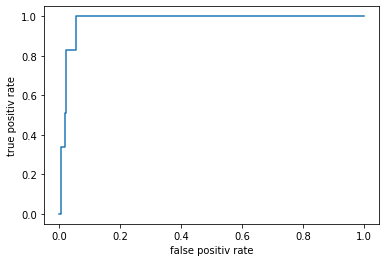

In [26]:
Scores, Roc = cross_validation(x, y, 7, testing = False)

## Evaluate model
 

In [27]:
# Evaluate mean and variance of each metric
nb_split = Roc.shape[0]

TP = np.zeros(nb_split)
TN = np.zeros(nb_split)
FP = np.zeros(nb_split)
FN = np.zeros(nb_split)
Acc = np.zeros(nb_split)
Pre = np.zeros(nb_split)
Rec = np.zeros(nb_split)
f1 = np.zeros(nb_split)

for k in range(nb_split):
  TP[k] = Scores[k][1][1]
  FN[k] = Scores[k][1][0]
  FP[k] = Scores[k][0][1]
  TN[k] = Scores[k][0][0]

  Acc[k] = (TP[k]+TN[k])/(TP[k]+FP[k]+FN[k]+TN[k])
  Pre[k] = TP[k]/(TP[k]+FP[k])
  Rec[k] = TP[k]/(TP[k]+FN[k])
  f1[k] = 2 * (Rec[k] * Pre[k]) / (Rec[k] + Pre[k])

mean_conf = np.array([[np.mean(TP), np.mean(FN)],[np.mean(FP), np.mean(TN)]])
var_conf = np.array([[np.sqrt(np.var(TP)), np.sqrt(np.var(FN))],[np.sqrt(np.var(FP)), np.sqrt(np.var(TN))]])
print('confusion')
print(mean_conf, var_conf)

mean_roc = np.mean(Roc)
var_roc = np.sqrt(np.var(Roc))
print('AUC Score')
print(mean_roc, var_roc)

mean_Acc = np.mean(Acc)
var_Acc = np.sqrt(np.var(Acc))
print('Accuracy')
print(mean_Acc, var_Acc)

mean_Pre = np.mean(Pre)
var_Pre = np.sqrt(np.var(Pre))
print('Precision')
print(mean_Pre, var_Pre)

mean_Rec = np.mean(Rec)
var_Rec = np.sqrt(np.var(Rec))
print('Recall')
print(mean_Rec, var_Rec)

mean_f1 = np.mean(f1)
var_f1 = np.sqrt(np.var(f1))
print('f1')
print(mean_f1, var_f1)

confusion
[[641.85714286 160.28571429]
 [ 41.42857143 760.71428571]] [[161.62604862 161.48393488]
 [ 20.68717438  20.43606256]]
AUC Score
0.9333899869541972 0.053493054747198024
Accuracy
0.8742516152245253 0.09147076384090762
Precision
0.9420008063982859 0.020526823248435383
Recall
0.8001425008906305 0.20135153975124775
f1
0.849504943874733 0.12492362985775042
